## Environment Setup

In [55]:
# Import Usual usage modules.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Import TensorFlow and Keras for GPU Usage
import tensorflow as tf
import keras 
from tensorflow.python.client import device_lib

# Import the Keras libraries and packages for usage
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import History
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# Import keras package for data augmentation
from keras.preprocessing.image import ImageDataGenerator
 
# For images (Navigating, writing, and loading)
import os
import imageio
from IPython.display import display
from PIL import Image

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check that the GPU is being utilized
print(tf.__version__)
print(keras.__version__)
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

1.9.0
2.2.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10386021041059731134
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4867584819
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16446035137760845642
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:01:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 4867584819
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9754725418827982393
physical_device_desc: "device: 1, name: GeForce GTX 980 Ti, pci bus id: 0000:02:00.0, compute capability: 5.2"
]


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## Preprocessing Data

I want to split up the image data I have so that they are organized by class, and eye (Left or Right)
    - Level 0 (Retinopathy Absent)
    - Level 1 (Mild Retinopathy)
    - Level 2 (Moderate Retinopathy)
    - Level 3 (Severe Retinopathy)
    - Level 4 (Proliferative Retinopathy)

I also want to split the data so that there is a clear folder for training data and testing data
    - Training/Classes/
    - Validation/Classes/

In [5]:
# Import the labels
df = pd.read_csv("DR_Labels_Cropped.csv")

In [8]:
# Import the necessary modules to move files around
import csv
import os

# Set the directories
SOURCE_ROOT = 'C:\\Users\\Mirwan\\Desktop\\Data Science\\Capstone\\resized_train_cropped\\'
DEST_ROOT = 'C:\\Users\\Mirwan\\Desktop\\Data Science\\Capstone\\All Images\\'

with open('DR_Labels_Cropped.csv') as infile:
    # Skip the header row
    next(infile)  
    reader = csv.reader(infile)
    seen = set()
    for image, level in reader:
        # Create a new directory if needed
        if level not in seen:
            os.mkdir(os.path.join(DEST_ROOT, level))
            seen.add(level)

        src = os.path.join(SOURCE_ROOT, image + '.jpeg')
        dest = os.path.join(DEST_ROOT, level, image + '.jpeg')

        try:
            os.rename(src, dest)
        except WindowsError as e:
            print(e)

Now we have the images all in separate class folders under the Training folder.

I want to split this set such that 80% of the data remains in Training, while 20% Goes to Validation

In [11]:
import split_folders

# Split with a ratio.
split_folders.ratio('All Images/', output="Split", seed=1337, ratio=(.8, .2))

I have to account for class balance. There is an imbalance here:

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64


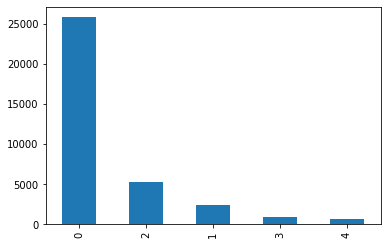

In [7]:
# Count and plot the sum of each level
df['level'].value_counts().plot(kind='bar')
print(df['level'].value_counts())

# Set y
y = df['level']

There should be no need to make modifications for this imbalance. The ratio at most is 50:1 for level 4 to none. That isn't so bad for the first build. This can be altered as optimizations occur.

## First Build of the CNN Model

There are multiple steps in creating a CNN for image classification.

CNN Models have a step-by-step process like the old models we had.

Instead of Instatiante, Fit, and Score, we do:

1 - **Initialize**
    - We set a variable to choose the type of model we want, similar to 'Instantiate'
2 - **Convolution**
    - Extracting features from the image, preserving the spatial relationship between pixels as it processes the image a square at a time
3 - **Pooling**
    - Reducings the dimensionality of each feature map, but keeping key information
4 - **Flatten**
    - Converts the matrix created from convolution, and pooling into a linear array so that it can be input into the Hidden Layer of the Neural Network
5 - **Connect**
    - This is connecting our CNN layers into a full web, front to back
6 - **Compile**
    - We put the model layers final parts together to complete it, such as which optimizer to use, what kind of classification we are aiming for with our dataset, and what metrics to emphasize
    - We are emphasizing 'Accuracy' because for medical imaging, it is the most important metric; especially when there is a human element regarding health and treatment
7 - **Augment**
    - We need a large amount of data to train such models
    - This can be achieved by augmenting the images by flipping them, rotating them, and translating them in any way.
    - This will reduce overfitting.
    - We can alter this as we redo our model to be more robust
8 - **Train and Visualize**
    - We visualize the accuracy of the training set, validation set, and the losses to see how we can adjust and improve the model to become more robust
    - We continue this until it reaches a point where we are satisfied with the result
    
Lets follow these steps and build a basic model to improve upon.
Below is a step by step process of how to build a CNN model.

This is a large dataset, with large images. This type of deep learning will require serious computational power. GPU usage from Tensorflow will help achieve this; however, with multiple gpus, we can speed this up much further, so it is helpful to try and leverage this additional horsepower.

This can be achieved using 'Data Parallelism', the splitting of batches to different gpus for processing so that they are running in parallel.

In [12]:
# Activating MULTI-GPU usage using Data Parallelism
def make_parallel(fn, num_gpus, **kwargs):
    in_splits = {}
    for k, v in kwargs.items():
        in_splits[k] = tf.split(v, num_gpus)

    out_split = []
    for i in range(num_gpus):
        with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
            with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
                out_split.append(fn(**{k : v[i] for k, v in in_splits.items()}))

    return tf.concat(out_split, axis=0)

This function now needs to be applied to the classifier used so that it is applied, and the workload is split across both GPUs and the CPU as opposed to one GPU with the CPU.

In [13]:
# Initialize the CNN model
classifier = Sequential()

### FIRST LAYER
# Step 1 - Convolution
classifier.add(Convolution2D(16, (3, 3), input_shape = (256, 256, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))
# ***Add Dropouts Between Layers To Reduce OVERFITTING*** 
classifier.add(Dropout(0.2))

### SECOND LAYER
classifier.add(Convolution2D(16, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.2))

### THIRD LAYER
classifier.add(Convolution2D(32, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.2))

### FOURTH LAYER
classifier.add(Convolution2D(32, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.2))

### MATRIX TO HIDDEN LAYER TO OUTPUT
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full Connection
classifier.add(Dense(output_dim = 256, activation = 'relu'))
classifier.add(Dense(output_dim = 5, activation = 'softmax'))

# Step 4b - Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### Check Model

In [14]:
# Check the summary of the model to see all the layers used
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
__________

### Data Augmentation

In [15]:
# Step 5 - Data Augmentation and Preprocessing

# Use package to augment the images in the dataset
# Create generators for Training / Validation / Test
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.5,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 45,
    width_shift_range = 0.15,
    height_shift_range = 0.15)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.5,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 45,
    width_shift_range = 0.15,
    height_shift_range = 0.15)

test_datagen = ImageDataGenerator(rescale = 1./255)

### Preparing Training Parameters

We need to split the Training Set and the Test Set, and set the hyperparameters of the model for the initial training. But how do we go about choosing these parameters?

#### Choosing a 'Batch-Size'

A larger batch size will give you a better gradient and will help to prevent jumping around (When visualizing graph accuracy and loss after training.)

You may also want to consider a smaller learning rate, or a learning rate scheduler (or decay) to allow the network to "settle in" as it trains

Too large of a batch_size can produce memory problems, especially if you are using a GPU. Once you exceed the limit, dial it back until it works. This will help you find the max batch-size that your system can work with.
Too large of a batch size can get you stuck in a local minima, so if your training get stuck, I would reduce it some. Imagine here you are over-correcting the jumping-around and it's not jumping around enough to further minimize the loss function.

#### When to reduce 'Epoch'

If your train error is very low, yet your test/validation is very high, then you have over-fit the model with too many epochs.
The best way to find the right balance is to use early-stopping with a validation test set. Here you can specify when to stop training, and save the weights for the network that gives you the best validation loss. I am using an early-stop here to help with overfitting, along with DropOut in the model layers themselves.

#### When to adjust 'Steps-Per-Epoch'

Traditionally, the steps per epoch is calculated as train_length // batch_size, since this will use all of the data points, one batch size worth at a time.

If you are augmenting the data, then you can stretch this a tad (sometimes I multiply that function above by 2 or 3 etc. But, if it's already training for too long, then just stick with the traditional approach.

In [74]:
# Split the dataset after the augmentation
training_set = train_datagen.flow_from_directory(
    'Split/train/',
    target_size = (256, 256),
    batch_size = 128,
    class_mode = 'sparse',
    shuffle = True)

validation_set = valid_datagen.flow_from_directory(
    'Split/val/',
    target_size = (256, 256),
    batch_size = 128,
    class_mode = 'sparse',
    shuffle = True)

# test_set = test_datagen.flow_from_directory(
#    'Split/test/',
#    target_size = (256, 256),
#    batch_size = 1,
#    class_mode = None)

Found 28084 images belonging to 5 classes.
Found 7024 images belonging to 5 classes.


In [19]:
# Validation Classes
print(validation_set.class_indices)
print(validation_set.classes)

# Training Classes
print(training_set.class_indices)
print(training_set.classes)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
[0 0 0 ... 4 4 4]
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
[0 0 0 ... 4 4 4]


Batch Size is the number of training examples that get processed at once or in a single batch. Higher number can lead to generalization issues as it can lose on fine detail. As Yann Lecun states: "Minibatch sizes larger than ... They learn quickly, but the wrong thing."

Steps per epoch is usually determined by the number of samples (In this case, 25,000) divided by the batch size (16), which is:

In [1]:
# Steps Per Epoch for Training Data
25000/128

195.3125

In [2]:
# Validation Steps
10000/128

78.125

If Data Augmentation is used, it is in good practice to increase this value a bit more than Total / Batch.

#### Training the Model

In [23]:
# Set the generator to create a validation set, and the parameters for how it will train.
make_parallel(classifier.fit_generator(
    generator = training_set,
    steps_per_epoch = 200, # (Total / Batch) + Data Aug
    epochs = 10,
    validation_data = validation_set,
    validation_steps = 80, # (Total / Batch) + Data Aug
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True), ReduceLROnPlateau(patience=2)]), 2)
model.save_weights('dr_first_try.h5')

Epoch 1/10
200/200 [==============================] - 878s 4s/step - loss: 0.8713 - acc: 0.7348 - val_loss: 0.8776 - val_acc: 0.7357
Epoch 2/10
200/200 [==============================] - 829s 4s/step - loss: 0.8693 - acc: 0.7335 - val_loss: 0.8836 - val_acc: 0.7344
Epoch 3/10
200/200 [==============================] - 850s 4s/step - loss: 0.8685 - acc: 0.7355 - val_loss: 0.8695 - val_acc: 0.7341
Epoch 4/10
200/200 [==============================] - 830s 4s/step - loss: 0.8606 - acc: 0.7384 - val_loss: 0.8716 - val_acc: 0.7324
Epoch 5/10
200/200 [==============================] - 829s 4s/step - loss: 0.8692 - acc: 0.7323 - val_loss: 0.8566 - val_acc: 0.7388
Epoch 6/10
200/200 [==============================] - 829s 4s/step - loss: 0.8711 - acc: 0.7333 - val_loss: 0.8669 - val_acc: 0.7340
Epoch 7/10
200/200 [==============================] - 822s 4s/step - loss: 0.8609 - acc: 0.7370 - val_loss: 0.8673 - val_acc: 0.7330
Epoch 8/10
200/200 [==============================] - 828s 4s/step - 

TypeError: 'History' object is not callable

#### Visualize the Results

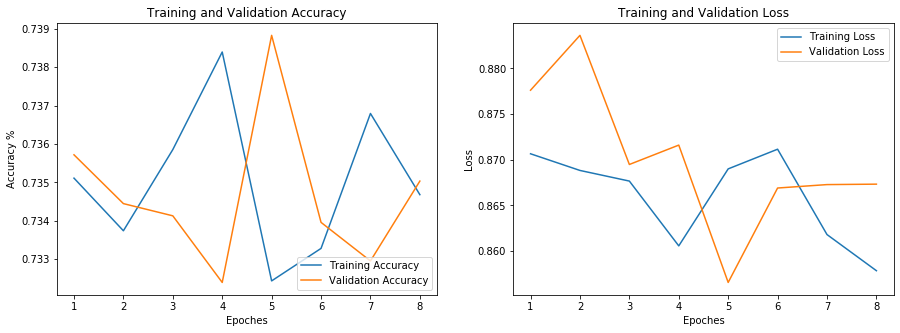

In [29]:
# We should plot the results of the models training
# Set the lists for each part of the models' history and the epochs used so we can plot them
acc = classifier.history.history['acc']
val_acc = classifier.history.history['val_acc']

loss = classifier.history.history['loss']
val_loss = classifier.history.history['val_loss']

epochs_range = np.arange(1,9)

# Make a subplot for 'loss' and one for 'accuracy'
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy %')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This can be further improved:

- The early stop part of the code has initiated, this is because there are minimal changes in the accuracy between epoches. This means I may be stuck in a local minima, and should reduce my batch size as I might be overstepping or understepping, then try again.
- The Training data hasn't been learned yet. The model is likely too simple for such a deep task.

Current Stats:

- Training Accuracy: 73%
- Validation Accuracy: 73%

### Building the CNN Model - Take Two

The top approach was very simple. Too simple for the task at hand. Each convolution layer is to detect features. Having too few or the layers too far in between won't allow the depth of features in retinal imaging to be detected. 

Here, I am attempting to reorganize the layers such that there are multiple convolution layers for each pooling layer. The Dropout has also increased, but due to there being less layers but more complicated ones, there are less Dropout instances altogether. 

A final Dropout has also been added to the FC (Fully Connected) layers.

In [78]:
# Model Architecture
classifier = Sequential()

classifier.add(Convolution2D(16, (3, 3), input_shape = (256, 256, 3)))
classifier.add(Activation('relu'))
classifier.add(Convolution2D(16, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(Convolution2D(16, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

classifier.add(Convolution2D(32, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(Convolution2D(32, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(Convolution2D(32, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

classifier.add(Flatten())
classifier.add(Dense(output_dim = 16))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.25))
classifier.add(Dense(output_dim = 5))
classifier.add(Activation('softmax'))

classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#### Check Model - Take Two

In [79]:
# Check the summary of the model to see all the layers used
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
activation_160 (Activation)  (None, 254, 254, 16)      0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 252, 252, 16)      2320      
_________________________________________________________________
activation_161 (Activation)  (None, 252, 252, 16)      0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 250, 250, 16)      2320      
_________________________________________________________________
activation_162 (Activation)  (None, 250, 250, 16)      0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 125, 125, 16)      0         
__________

#### Training the Model - Take Two

In [80]:
# Set the generator to create a validation set, and the parameters for how it will train.
make_parallel(classifier.fit_generator(
    generator = training_set,
    steps_per_epoch = 400, # (Total / Batch) + Data Aug
    epochs = 10,
    validation_data = validation_set,
    validation_steps = 160, # (Total / Batch) + Data Aug
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True), ReduceLROnPlateau(patience=2)]), 2)
model.save_weights('dr_second_model.h5')

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[64,32,119,119] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_7/Adam/gradients/max_pooling2d_54/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 2, 2], padding="VALID", strides=[1, 1, 2, 2], _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_165/Relu, max_pooling2d_54/MaxPool, training_7/Adam/gradients/AddN_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


#### Visualize the Results - Take Two

In [ ]:
# We should plot the results of the models training
# Set the lists for each part of the models' history and the epochs used so we can plot them
acc = classifier.history.history['acc']
val_acc = classifier.history.history['val_acc']

loss = classifier.history.history['loss']
val_loss = classifier.history.history['val_loss']

epochs_range = np.arange(1,11)

# Make a subplot for 'loss' and one for 'accuracy'
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()